In [3]:
#faiss install on colab issue: https://discuss.huggingface.co/t/cannot-install-faiss-in-google-collab/39451/3 | https://stackoverflow.com/questions/58957169/faiss-error-could-not-find-a-version-that-satisfies-the-requirement-faiss-from
!sudo apt-get install libomp-dev
!pip install faiss-gpu-cu12
#do this in Collab since transformers lib have mismatch numpy lib with faiss-gpu
!pip uninstall transformers
!pip install transformers

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libomp-dev is already the newest version (1:14.0-55~exp2).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.11/dist-packages/transformers-4.51.3.dist-info/*
    /usr/local/lib/python3.11/dist-packages/transformers/*
Proceed (Y/n)? y
  Successfully uninstalled transformers-4.51.3
  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
Using cached transformers-4.51.3-py3-none-any.whl (10.4 MB)


In [1]:
import torch
from transformers import pipeline, CLIPProcessor, CLIPModel
import faiss
from PIL import Image
import os
#google drive auth
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cuda


In [11]:
class clip_image_search():
  def __init__(self):
    #clip model init
    self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    self.clip_model.eval()

    #faiss for indexing img embeddings
    self.faiss_index = None

  def init_and_index_faiss(self, embedding_dimension, embeddings, img_paths, search_metric='l2'):
    #L2 or cosine similarity search metric
    if search_metric == 'l2':
      self.faiss_index = faiss.IndexFlatL2(embedding_dimension)
    elif search_metric == 'ip':
      self.faiss_index = faiss.IndexFlatIP(embedding_dimension)


    #attach ids to faiss index
    img_ids = [i for i in range(len(img_paths))]
    #wrap with IndexIDMap to associate vectors with ids:
    #https://medium.com/data-science/building-an-image-similarity-search-engine-with-faiss-and-clip-2211126d08fa
    self.faiss_index_wIds = faiss.IndexIDMap(self.faiss_index)
    #add vectors to index
    self.faiss_index_wIds.add_with_ids(embeddings, img_ids)

    return self.faiss_index_wIds

  def encode_imgs(self, img_folder):
    embedded_imgs_list = []
    img_paths = [os.path.join(img_folder, img_path) for img_path in os.listdir(img_folder)]
    imgs = [Image.open(img_path).convert('RGB') for img_path in img_paths]
    with torch.no_grad():
      processed_imgs = self.clip_processor(text=None, images=imgs, return_tensors="pt", padding=True, use_fast=True)
      img_embeddings = self.clip_model.get_image_features(**processed_imgs.to(device))

      #faiss needs embeedings in f32
      img_embeddings = img_embeddings.cpu().numpy().astype('float32')
      embedding_dimenstion = img_embeddings.shape[1]

      #init faiss index
      self.init_and_index_faiss(embedding_dimenstion, img_embeddings, img_paths, search_metric="l2")

      for an_img_path, an_img_embedding in zip(img_paths, img_embeddings):
        embedded_imgs_list.append([an_img_path, an_img_embedding])
    return embedded_imgs_list

  def encode_text_prompt(self, text):
    with torch.no_grad():
      text_inputs = self.clip_processor(text=text, return_tensors="pt", padding=True)
      text_embeddings = self.clip_model.get_text_features(**text_inputs.to(device))

    return text_embeddings.cpu().numpy().astype('float32')

  def search_imgs(self, text_query, result_limit=5):
    text_query_embedding = self.encode_text_prompt(text_query)
    distance, indices = self.faiss_index_wIds.search(text_query_embedding, result_limit)
    return distance, indices

  def display_images(self, img_folder, indices):
    img_paths = [os.path.join(img_folder, img_path) for img_path in os.listdir(img_folder)]
    for index in indices[0]:
      img = Image.open(img_paths[index])
      display(img)

In [12]:
#init class, clip encoders
clip_img_search_obj = clip_image_search()
img_folder = '/content/drive/MyDrive/image-search-project/image-search-data'

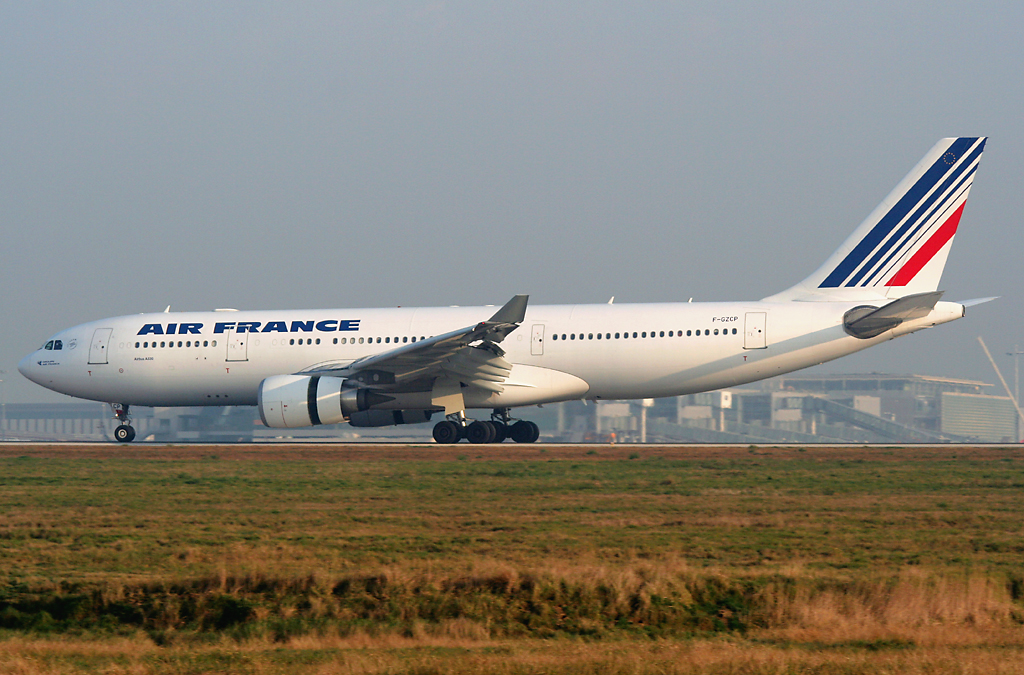

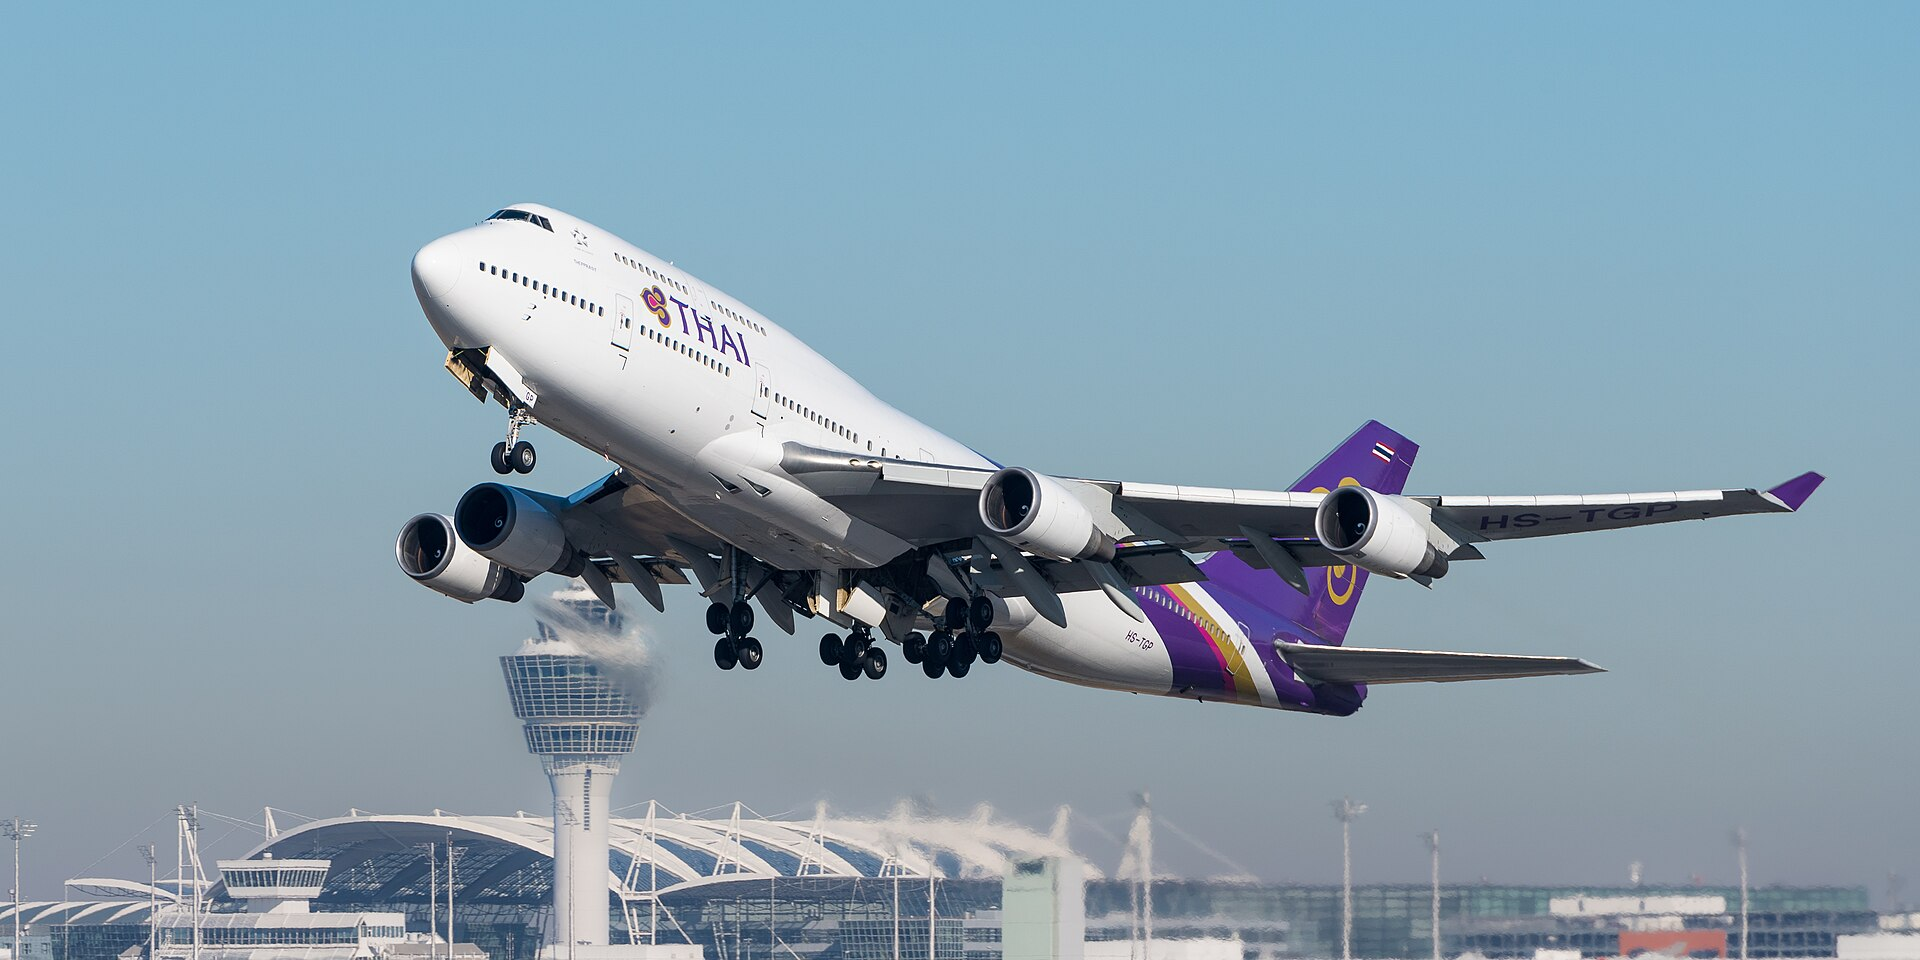

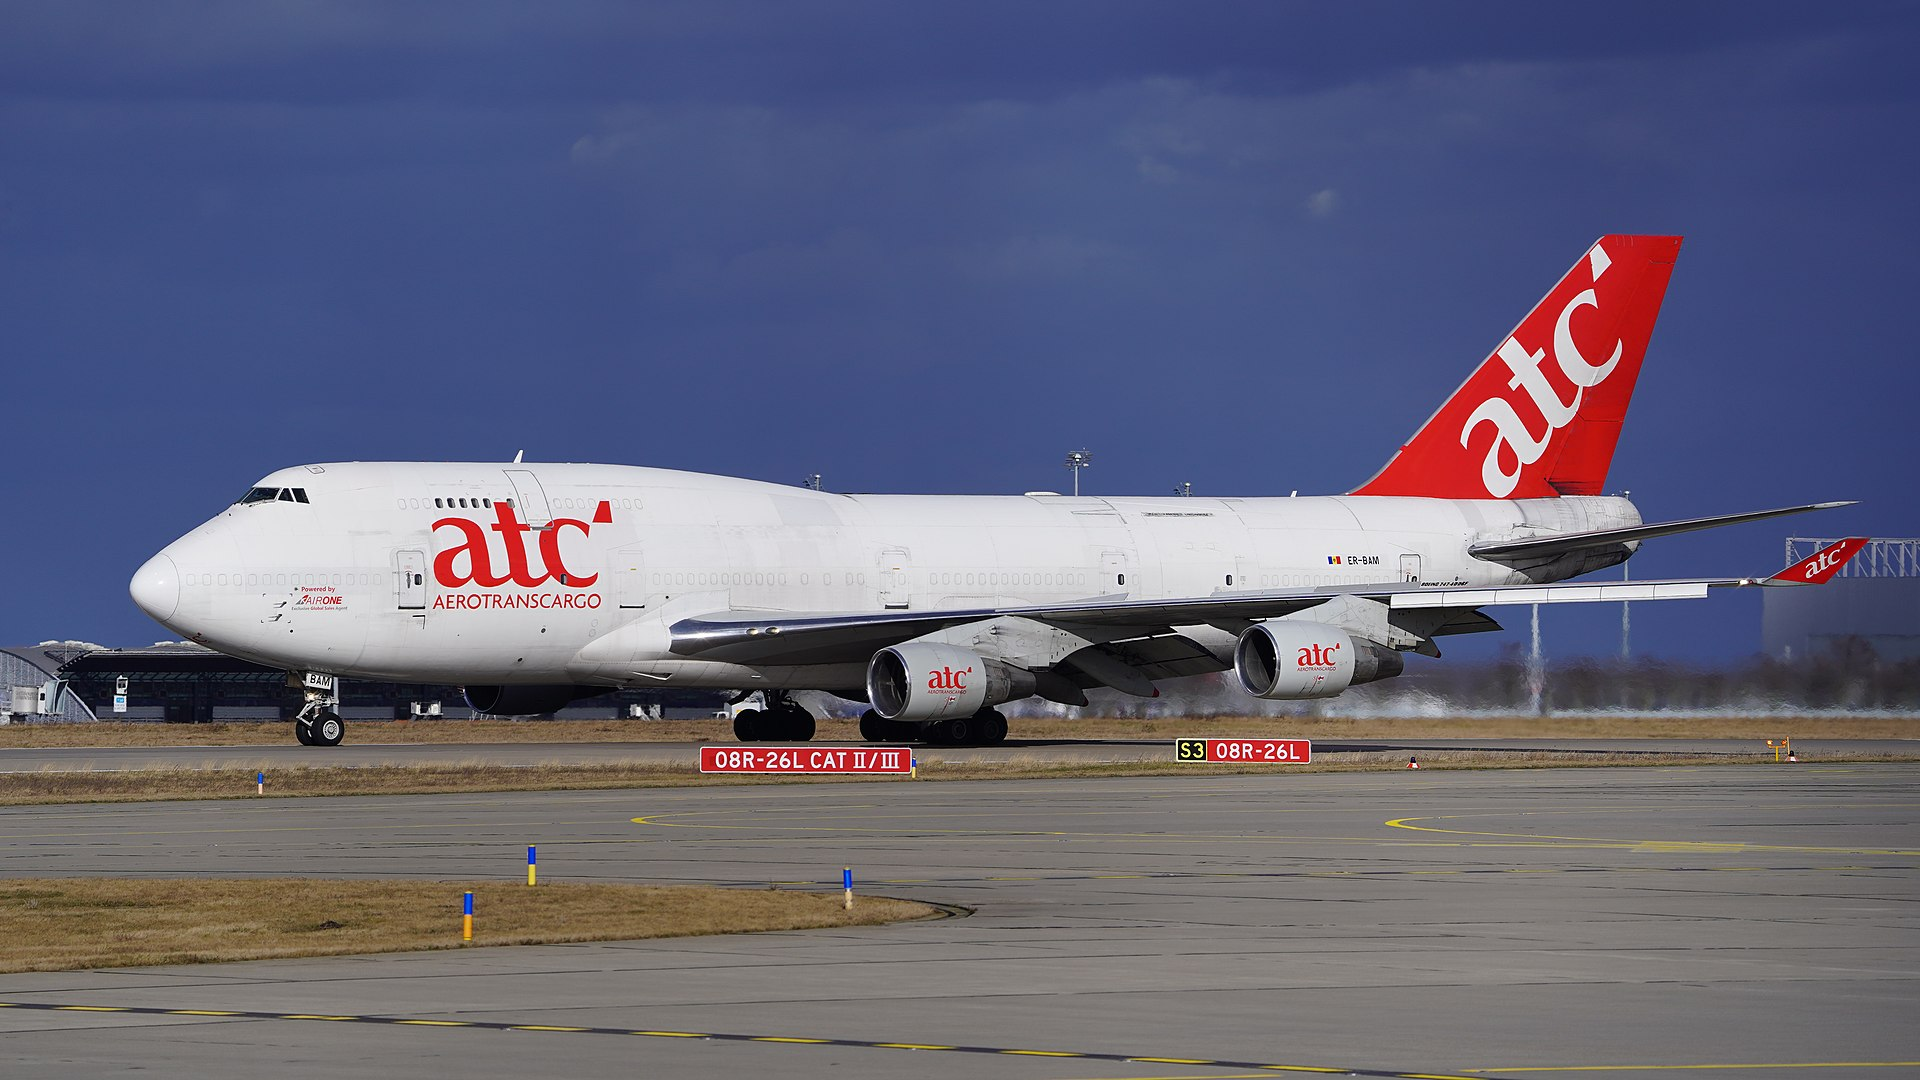

In [17]:
#search using prompts
clip_img_search_obj.encode_imgs(img_folder)
_, queried_indicies = clip_img_search_obj.search_imgs('planes', result_limit=3)
clip_img_search_obj.display_images(img_folder, queried_indicies)